In [61]:
import numpy as np

class LinearDynamics:
    def __init__(self, A, B):
        self.A = A
        self.B = B

class LinearCost:
    def __init__(self, Q, R, Qf):
        self.Q = Q
        self.R = R
        self.Qf = Qf

class LinearConstraints:
    def __init__(self, xlb, xub, ulb, uub):
        self.xlb = xlb
        self.xub = xub
        self.ulb = ulb
        self.uub = uub

class MPCSolver:
    def __init__(self, dyn:LinearDynamics, cost:LinearCost, constraints:LinearConstraints, N, rho):
        self.dyn = dyn
        self.cost = cost
        self.constraints = constraints

        # Problem dimensions
        self.N = N # time horizon
        self.nu = dyn.B.shape[1]
        self.nx = dyn.A.shape[0]

        # MPC parameters
        self.rho = rho

        # Cached matrices
        self.Pinf = np.zeros((self.nx, self.nx))
        self.Kinf = np.zeros((self.nu, self.nx))
        self.C1 = np.zeros((self.nu, self.nu)) # Quu_inv
        self.C2 = np.zeros((self.nx, self.nx)) # AmBKt
        self.C3 = np.zeros((self.nx, self.nu)) # coeff_d2p
        self.cache_matrices()

        # reference state trajectory
        self.xref = np.zeros((self.nx, self.N))
        
        # State and input trajectories
        self.x = np.zeros((self.nx, self.N))
        self.u = np.zeros((self.nu, self.N-1))

        # Linear control cost terms
        self.q = np.zeros((self.nx, self.N))
        self.r = np.zeros((self.nu, self.N-1))

        # Linear Riccati backward pass terms
        self.p = np.zeros((self.nx, self.N))
        self.d = np.zeros((self.nu, self.N-1))

        # auxiliary variables; notation is different from paper.
        # TODO: change notation
        self.v = np.zeros((self.nx, self.N))
        self.vnew = np.zeros((self.nx, self.N))
        self.z = np.zeros((self.nu, self.N-1))
        self.znew = np.zeros((self.nu, self.N-1))

        # Dual variables
        self.g = np.zeros((self.nx, self.N))
        self.y = np.zeros((self.nu, self.N-1))


    def cache_matrices(self):
        # First, compute the infinite-horizon LQR solution
        Pinf, Kinf = self.infinite_horizon_lqr()

        self.Pinf[:] = Pinf
        self.Kinf[:] = Kinf

        # Compute the cached matrices
        self.C1[:] = np.linalg.inv(self.cost.R + self.dyn.B.T @ self.Pinf @ self.dyn.B)
        self.C2[:] = np.transpose(self.dyn.A - self.dyn.B @ self.Kinf)
        self.C3[:] = self.Kinf.T @ self.cost.R  - self.C2 @ self.Pinf @ self.dyn.B

    def infinite_horizon_lqr(self):
        # riccati recursion to get Kinf, pINF
        Ktp1 = np.zeros((self.nu, self.nx))
        Ptp1 = self.rho * np.eye(self.nx)
        Kinf = np.zeros((self.nu, self.nx))
        Pinf = np.zeros((self.nx, self.nx))
        
        R1 = self.cost.R + np.eye(self.nu) * self.rho
        Q1 = self.cost.Q + np.eye(self.nx) * self.rho

        for i in range(7000):
            Kinf[:] = np.linalg.inv(R1+ self.dyn.B.T @ Ptp1 @ self.dyn.B) @ \
            self.dyn.B.T @ Ptp1 @ self.dyn.A
            Pinf[:] = Q1 + self.dyn.A.T @ Ptp1 @ self.dyn.A - self.dyn.A.T @ Ptp1 @ self.dyn.B @ Kinf
            Ktp1[:] = Kinf
            Ptp1[:] = Pinf
            
        print("Kinf: \r\n", Kinf)
        print("Pinf: \r\n", Pinf)

        return Pinf, Kinf
    
    def backward_pass(self):
        for i in range(self.N-2, -1, -1):
            self.d[:,i] = self.C1 @ (self.dyn.B.T @ self.p[:,i+1] + self.r[:,i])
            self.p[:,i] = self.q[:,i] + self.C2 @ self.p[:,i+1] - self.Kinf.T @ self.r[:,i] + self.C3 @ self.d[:,i]
            # self.p[:,i] = self.q[:,i] + self.C2 @ self.p[:,i+1] - self.Kinf.T @ self.r[:,i] # wierd behavior: algorithm diverges if C3 is included
    def forward_pass(self):
        for i in range(self.N-1):
            self.u[:,i] =  - self.Kinf @ self.x[:,i] - self.d[:,i]
            self.x[:,i+1] = self.dyn.A @ self.x[:,i] + self.dyn.B @ self.u[:,i]
    
    def update_slack(self):
        # project to feasible set (element-wise min and max)
        tmp_znew = self.u + self.y
        tmp_vnew = self.x + self.g

        # TODO: vectorize this
        self.znew[:] = np.maximum(np.minimum(tmp_znew, self.constraints.uub), self.constraints.ulb)
        self.vnew[:] = np.maximum(np.minimum(tmp_vnew, self.constraints.xub), self.constraints.xlb)

    def update_dual(self):
        self.y[:] = self.y + self.u - self.znew
        self.g[:] = self.g + self.x - self.vnew

    def update_linear_cost(self):
        self.r[:] = 0 - self.rho * (self.znew - self.y) # update r 1:N-1; No uref in this case
        self.q[:] = - self.cost.Q.T @ self.xref - self.rho * (self.vnew - self.g) # update q 1:N 
        self.p[:,-1] = - self.xref[:,-1].T @ self.Pinf  - self.rho * (self.vnew[:,-1] - self.g[:,-1])# update p N

    def solve(self, xref):

        self.xref[:] = xref

        for i in range(100):
            self.forward_pass()
            self.update_slack()
            self.update_dual()
            self.update_linear_cost()
            self.v[:] = self.vnew
            self.z[:] = self.znew
            self.backward_pass()





    
    

Kinf: 
 [[3.39821276 4.45630132]]
Pinf: 
 [[13.12677557  2.94566606]
 [ 2.94566606  3.56828028]]
[2.99898069 0.01857188]


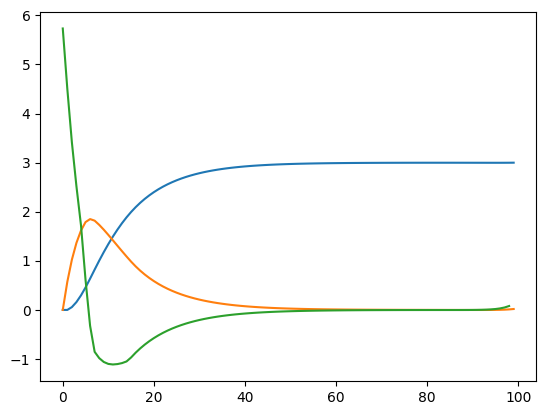

In [69]:
# test case: double integrator
dt = 0.1
N = 100

dyn = LinearDynamics(np.array([[1, dt], [0, 1]]), np.array([[0], [dt]]))
cost = LinearCost(np.eye(2), np.eye(1) * 0.05, np.eye(2))
constraints = LinearConstraints(-np.ones((2,1)) * 20, np.ones((2,1)) * 20, -np.ones((1,1)) * 1, np.ones((1,1)) * 1)

mpc = MPCSolver(dyn, cost, constraints, N, 0.001)
mpc.solve(np.zeros((2,N))+[[3],[0]])


import matplotlib.pyplot as plt
plt.plot(mpc.x[0,:])
plt.plot(mpc.x[1,:])
plt.plot(mpc.u[0,:])

print(mpc.x[:,-1])
